In [25]:
import pandas as pd
import numpy as np

df = pd.read_json('../data/raw/full_property.json')

In [26]:
# take a look at the size of the data
df.shape

(12, 11206)

In [27]:
# there are 12 rows in the data, but we have 12 features,
# so data needs to have 12 columns instead -- need to transpose this data

df = df.transpose()
df.head()

,name,cost_text,coordinates,Bed,Bath,Park,property_type,desc_head,desc,additional features,internal_area_sqkm,land_area_sqkm
https://www.domain.com.au/unit-503-466-swanston-street-carlton-vic-3053-16066115,unit 503/466 Swanston Street Carlton VIC 3053,$320,"[-37.8059838, 144.9632701]",1,1,0,Apartment / Unit / Flat,Fully Furnished Studio Apartment in Swanston,"class=""css-dxogle"">* Unverified feature<svg a...","[Alarm System, Built in wardrobes, Intercom]",[],[]
https://www.domain.com.au/61-rowans-road-highett-vic-3190-16080336,61 Rowans Road Highett VIC 3190,$460.00,"[-37.9475765, 145.0509956]",3,1,1,House,Quaint three bedroom in a great location!,"class=""css-dxogle"">* Unverified feature<svg a...","[Split System Air Con, Split System Heating, E...",NaN,[]
https://www.domain.com.au/29-caspian-circuit-point-cook-vic-3030-16023583,29 Caspian Circuit Point Cook VIC 3030,$430.00 per week,"[-37.9002294, 144.7452156]",3,2,2,House,Life at Your Fingertips,"class=""css-dxogle"">* Unverified feature<svg a...",[],NaN,[]
https://www.domain.com.au/36-bradleys-lane-north-warrandyte-vic-3113-16038589,36 Bradleys Lane North Warrandyte VIC 3113,$720 per week,"[-37.7370336, 145.2124356]",4,3,3,House,Bradleys Lane,"class=""css-dxogle"">* Unverified feature<svg a...",[],NaN,[]
https://www.domain.com.au/12-isaac-road-keysborough-vic-3173-16020786,12 Isaac Road Keysborough VIC 3173,$515 pw,"[-37.9840266, 145.1782469]",3,3,1,House,LUXURY SUBURBAN LIVING,"class=""css-dxogle"">* Unverified feature<svg a...","[Built in wardrobes, Dishwasher]",NaN,[]


In [28]:
type(df["coordinates"][0])

list

### 1: Cost

In [29]:
# the cost of a real estate property is in dollars per week.
# I will transform all the values in the cost_text column into integers.

df2 = df.copy()
import re


# the list of instances where the values are ambiguous or invalid,
# each instance will be in the form of (index, string)
ambiguous = dict()

for i in range(df2.shape[0]):
    cost = re.findall(r"[\d,]+", df2.iat[i, 1])

    if len(cost) == 0:
        df2.iat[i, 1] = np.nan
    
    else:
        # find the element with length 3, since it's the most likely one
        cost2 = [i for i in cost if len(i) == 3]

        if len(cost2) == 1:
            # if there's only one, then it's very likely that it's the correct price we want
            df2.iat[i, 1] = int(cost2[0])

        else:
            # otherwise, this is where things get wacky
            string = df2.iat[i, 1]
        
            # if there is no mention, assume the price is per week
            # there will be outliers, but they can be detected and removed afterwards.

            # if only monthly or yearly price is listed, simply get the estimate by dividing 4 or 52.
            week = ["/w", "pw", "PW", "Week", "week"]
            month = ["pcm", "PCM", "pm", "PM", "mth", "month", "Month", "MONTH"]
            annual = ["p.a", "pa", "Annually"]

            # none of month or annual price is listed, so the listed price is likely to be per week
            if not any(sub_month in string for sub_month in month) and \
                not any(sub_annual in string for sub_annual in annual):
                # dealing with N,NNN.NN format
                if len(cost) == 1:
                    df2.iat[i, 1] = int(cost[0].replace(",", ""))
                elif len(cost) == 2 and len(cost[1]) == 2:
                    df2.iat[i, 1] = int(cost[0].replace(",", "")) + float(f"0.{cost[1]}")
                else:
                    # the only other alternative to this is to clean it manually.
                    # However, we actually end up with 59 values left *in total*,
                    # and doing so manually is going to be extremely tedious. Therefore, I opt
                    # to sacrifice the tedious-ness with a slightly higher chance of picking
                    # up false positives (i.e., picking up values that shouldn't be picked up)
                    # by taking cost[0] as the true rent price.
                    df2.iat[i, 1] = int(cost[0].replace(",", ""))

                    # you can see the cost_text string by looking at this dict value
                    ambiguous[i] = string

            # weekly price is listed
            elif any(sub_week in string for sub_week in week):
                # dealing with N,NNN.NN format
                if len(cost) == 1:
                    df2.iat[i, 1] = int(cost[0].replace(",", ""))
                elif len(cost) == 2 and len(cost[1]) == 2:
                    df2.iat[i, 1] = int(cost[0].replace(",", "")) + float(f"0.{cost[1]}")
                else:
                    df2.iat[i, 1] = int(cost[0].replace(",", ""))
                    ambiguous[i] = string

            # only monthly price is listed
            elif any(sub_month in string for sub_month in month) and \
                not any(sub_week in string for sub_week in week) and \
                not any(sub_annual in string for sub_annual in annual):
                if len(cost) == 1:
                    df2.iat[i, 1] = int(cost[0].replace(",", "")) / 4
                elif len(cost) == 2 and len(cost[1]) == 2:
                    df2.iat[i, 1] = (int(cost[0].replace(",", "")) + float(f"0.{cost[1]}")) / 4
                else:
                    df2.iat[i, 1] = int(cost[0].replace(",", ""))
                    ambiguous[i] = string

            # only annual price price is listed
            elif not any(sub_month in string for sub_month in month) and \
                not any(sub_week in string for sub_week in week) and \
                any(sub_annual in string for sub_annual in annual):
                if len(cost) == 1:
                    df2.iat[i, 1] = int(cost[0].replace(",", "")) / 52
                elif len(cost) == 2 and len(cost[1]) == 2:
                    df2.iat[i, 1] = (int(cost[0].replace(",", "")) + float(f"0.{cost[1]}")) / 52
                else:
                    df2.iat[i, 1] = int(cost[0].replace(",", ""))
                    ambiguous[i] = string

            else:
                df2.iat[i, 1] = int(cost[0].replace(",", ""))
                ambiguous[i] = string

ambiguous


{954: '$1099pw - Stay 1 mth+',
 1045: '$1190pw Stay 1 mth',
 1166: '$1050pw Stay 1 mth',
 1723: '$1100 PW / $4780 PCM',
 1975: '$1029pw - Stay 1 mth+',
 2093: '$325 Per Week Until April 2022. Increase to $335 Per Week a',
 2293: '$220.00 pw- (rent increase to $285 pw from 25/1/23',
 2414: '$195 per week - Then $245 per week from 10/02/2023',
 2544: 'APPLY NOW - Studio From $250/w & 2 Bed From $385/w',
 2554: '$3,000 per month, plus GST & Outgoings',
 2751: '$560pw/$2.433pcm',
 2758: '$185 Per Week - $195pw from 03/02/2023',
 2868: '$240 pw until 20/01/2023 then increase to $320pw',
 3178: '$1036pw - Stay 1 mth+',
 3357: '$750 per week 750',
 3425: '$1015pw - Stay 1 mth+',
 3478: '$950pw/$4.128pcm',
 3817: '$480 per week 480.00',
 3845: '$750 to $775',
 4087: '$260 to $280',
 4137: '$2300pw / $9994pcm',
 4207: 'From $155 - $285 pw (bills included)',
 5045: '$1246pw - Stay 1 mth+',
 5460: '($1,350 pcm + $2,150 pcm)',
 5826: '$1800pw / $7821pcm',
 6079: '$1200pw - Stay 1 mth+',
 6090: '$1

{'whiskers': [<matplotlib.lines.Line2D at 0x7f5a1e3a6a90>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5a1e3a62e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5a1e3b1d00>],
 'medians': [<matplotlib.lines.Line2D at 0x7f5a1e3a6e20>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f5a1e3b51f0>],
 'means': []}

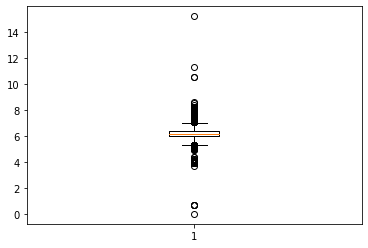

In [30]:
# visualise the distribution of cost_text
import math, statistics
import matplotlib.pyplot as plt

cost_text = df2["cost_text"].to_list()
cost_text = [i for i in cost_text if not math.isnan(i)]
plt.boxplot(np.log(cost_text))

### 2: Description

In [31]:
# might need to install these libraries first
import enchant   
import nltk
from nltk.stem import PorterStemmer

def preprocess_text(text):
    # preprocesses a string of texts :)
    
    # step 1: remove non-alphabetic characters
    text = re.sub(r'[^a-z\sA-Z]', ' ', text)
    # step 2: convert all spacing characters such as tabs and newlines to 
    # whitespace and ensure that only one whitespace character exists between each word
    text = re.sub(r'\s+', ' ', text)
    # step 3: Change all uppercase characters to lower case
    text = text.lower()
    # step 4: tokenise into words
    words = text.split()
    # step 5: remove invalid English words and single-letter words, and then stemming
    d = enchant.Dict('en')
    ps = PorterStemmer()
    words = [ps.stem(i) for i in words if(d.check(i) == True) and (len(i) > 1)]
    return words

In [32]:
df3 = df2.copy()


for i in range(df3.shape[0]):
    # there are many instances with invalid descriptions, 
    # and fortunately, they seem relatively easy to find.
    invalid = re.findall(r'class="', df3.iat[i, 8])
    if invalid:
        df3.iat[i, 8] = np.nan

    # text preprocessing
    # I'm not sure how useful this "desc" attribute is going to be,
    # so if you wanna use this attribute, just uncomment this part of the code
    # just note that it will take a while to run
    #else:
    #    df3.iat[i, 8] = preprocess_text(df3.iat[i, 8])

#df3.head(3)
df3.where(df3['coordinates'] == "Not Listed").count()

name                   13
cost_text               0
coordinates            13
Bed                    13
Bath                   13
Park                   13
property_type          13
desc_head              13
desc                   11
additional features    13
internal_area_sqkm      0
land_area_sqkm         13
dtype: int64

In [33]:
df3.head(3)

,name,cost_text,coordinates,Bed,Bath,Park,property_type,desc_head,desc,additional features,internal_area_sqkm,land_area_sqkm
https://www.domain.com.au/unit-503-466-swanston-street-carlton-vic-3053-16066115,unit 503/466 Swanston Street Carlton VIC 3053,320,"[-37.8059838, 144.9632701]",1,1,0,Apartment / Unit / Flat,Fully Furnished Studio Apartment in Swanston,NaN,"[Alarm System, Built in wardrobes, Intercom]",[],[]
https://www.domain.com.au/61-rowans-road-highett-vic-3190-16080336,61 Rowans Road Highett VIC 3190,460,"[-37.9475765, 145.0509956]",3,1,1,House,Quaint three bedroom in a great location!,NaN,"[Split System Air Con, Split System Heating, E...",NaN,[]
https://www.domain.com.au/29-caspian-circuit-point-cook-vic-3030-16023583,29 Caspian Circuit Point Cook VIC 3030,430,"[-37.9002294, 144.7452156]",3,2,2,House,Life at Your Fingertips,NaN,[],NaN,[]


### Final 3 features

In [80]:
# only need to replace empty list with NaN values
for i in range(df3.shape[0]):
    try:
        # there is definitely a better way to do this than try except, but this works so
        if len(df3.iat[i, -1]) == 0:
            df3.iat[i, -1] = np.nan
    except:
        pass

    try: 
        if len(df3.iat[i, -2]) == 0:
            df3.iat[i, -2] = np.nan
    except TypeError:
        pass
    try:
        if len(df3.iat[i, -3]) == 0:
            df3.iat[i, -3] = np.nan
    except TypeError:
        pass
df3 = df3[df3["coordinates"] != "Not Listed"]
df3.head(5)

,name,cost_text,coordinates,Bed,Bath,Park,property_type,desc_head,desc,additional features,internal_area_sqkm,land_area_sqkm
https://www.domain.com.au/unit-503-466-swanston-street-carlton-vic-3053-16066115,unit 503/466 Swanston Street Carlton VIC 3053,320,"[-37.8059838, 144.9632701]",1,1,0,Apartment / Unit / Flat,Fully Furnished Studio Apartment in Swanston,NaN,"[Alarm System, Built in wardrobes, Intercom]",NaN,NaN
https://www.domain.com.au/61-rowans-road-highett-vic-3190-16080336,61 Rowans Road Highett VIC 3190,460,"[-37.9475765, 145.0509956]",3,1,1,House,Quaint three bedroom in a great location!,NaN,"[Split System Air Con, Split System Heating, E...",NaN,NaN
https://www.domain.com.au/29-caspian-circuit-point-cook-vic-3030-16023583,29 Caspian Circuit Point Cook VIC 3030,430,"[-37.9002294, 144.7452156]",3,2,2,House,Life at Your Fingertips,NaN,NaN,NaN,NaN
https://www.domain.com.au/36-bradleys-lane-north-warrandyte-vic-3113-16038589,36 Bradleys Lane North Warrandyte VIC 3113,720,"[-37.7370336, 145.2124356]",4,3,3,House,Bradleys Lane,NaN,NaN,NaN,NaN
https://www.domain.com.au/12-isaac-road-keysborough-vic-3173-16020786,12 Isaac Road Keysborough VIC 3173,515,"[-37.9840266, 145.1782469]",3,3,1,House,LUXURY SUBURBAN LIVING,NaN,"[Built in wardrobes, Dishwasher]",NaN,NaN


Before saving the dataframe to csv, additional preprocessing might be required

In [82]:
df4 = pd.concat([pd.DataFrame(df3['coordinates'].to_list()), df3.reset_index()], axis=1)
df4.drop("coordinates", axis=1, inplace=True)
df4.rename(columns={0:'latitude', 1:"longitude"}, inplace=True)

# save to csv
filename = "../data/raw/full_property_data.csv"
df4.to_csv(filename)

In [83]:
df4.head()

,latitude,longitude,index,name,cost_text,Bed,Bath,Park,property_type,desc_head,desc,additional features,internal_area_sqkm,land_area_sqkm
0,-37.805984,144.963270,https://www.domain.com.au/unit-503-466-swansto...,unit 503/466 Swanston Street Carlton VIC 3053,320,1,1,0,Apartment / Unit / Flat,Fully Furnished Studio Apartment in Swanston,NaN,"[Alarm System, Built in wardrobes, Intercom]",NaN,NaN
1,-37.947576,145.050996,https://www.domain.com.au/61-rowans-road-highe...,61 Rowans Road Highett VIC 3190,460,3,1,1,House,Quaint three bedroom in a great location!,NaN,"[Split System Air Con, Split System Heating, E...",NaN,NaN
2,-37.900229,144.745216,https://www.domain.com.au/29-caspian-circuit-p...,29 Caspian Circuit Point Cook VIC 3030,430,3,2,2,House,Life at Your Fingertips,NaN,NaN,NaN,NaN
3,-37.737034,145.212436,https://www.domain.com.au/36-bradleys-lane-nor...,36 Bradleys Lane North Warrandyte VIC 3113,720,4,3,3,House,Bradleys Lane,NaN,NaN,NaN,NaN
4,-37.984027,145.178247,https://www.domain.com.au/12-isaac-road-keysbo...,12 Isaac Road Keysborough VIC 3173,515,3,3,1,House,LUXURY SUBURBAN LIVING,NaN,"[Built in wardrobes, Dishwasher]",NaN,NaN
